In [38]:
import dataRead
import dataClean

import runTrain
import runTest
import writeResult

In [39]:
# Read data
reload(dataRead)
X_train,X_test,word_vecs = dataRead.do()

In [ ]:
# Test Above function here


In [312]:
reload(dataClean)
X_train_features,X_test_features = dataClean.clean(X_train,X_test)
X_train_features,X_test_features = dataClean.getWordVectors(X_train_features,X_test_features,word_vecs)
X_train_features,X_test_features = dataClean.getSentenceVectors(X_train_features,X_test_features)

In [313]:
# Test Above function here

In [55]:
# Train model
reload(runTrain)
runTrain.do(X_train_features)

In [6]:
# Test Above function here


In [68]:
# Test model
reload(runTest)
result = runTest.do(X_test_features)

In [69]:
# Test Above function here


In [124]:
# Get Loss of result
reload( getLoss)
getLoss.do(result,X_train_features)

('EAP:',
 0.67440277290272199,
 'MWS:',
 0.61805501993181355,
 'HPL:',
 0.60017764704326304)

In [ ]:
# Test Above function here


In [97]:
# Write Results
reload(writeResult)
writeResult.do(result,X_test_features)

In [ ]:
# Test Above function here

In [125]:
#                          #
# Add test functions below #
#                          #


In [ ]:
# Plots
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook()

la = np.linalg
author = [author for author in X_train_features['author']]
X = [sentence for sentence in X_train_features['sentence_vectors']]
U, s, Vh = la.svd(X, full_matrices = False)

#plot
col = {'EAP':'red','MWS':'cyan','HPL':'yellow'}
for i in range(1000):
    plt.scatter(U[i,0], U[i,1],color = col[author[i]])
plt.plot()

mean-train 149.07 std-train 106.81 mean-test 147.77 std-test 109.66 max-train 4663.00 max-test 4437.00


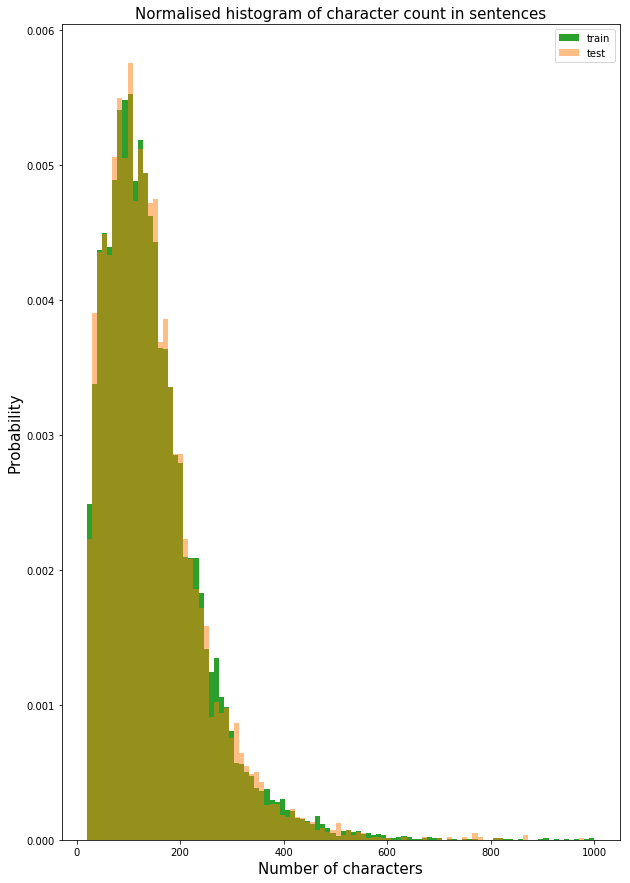

In [228]:
# Character Count
import seaborn as sns
pal = sns.color_palette()

train_sents = pd.Series(X_train['text'].tolist()).astype(str)
test_sents = pd.Series(X_test['text'].tolist()).astype(str)

dist_train = train_sents.apply(len)
dist_test = test_sents.apply(len)
plt.figure(figsize=(10, 15))
plt.hist(dist_train, bins=100, range=[20, 1000], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=100, range=[20, 1000], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in sentences', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

Text(0,0.5,u'Probability')

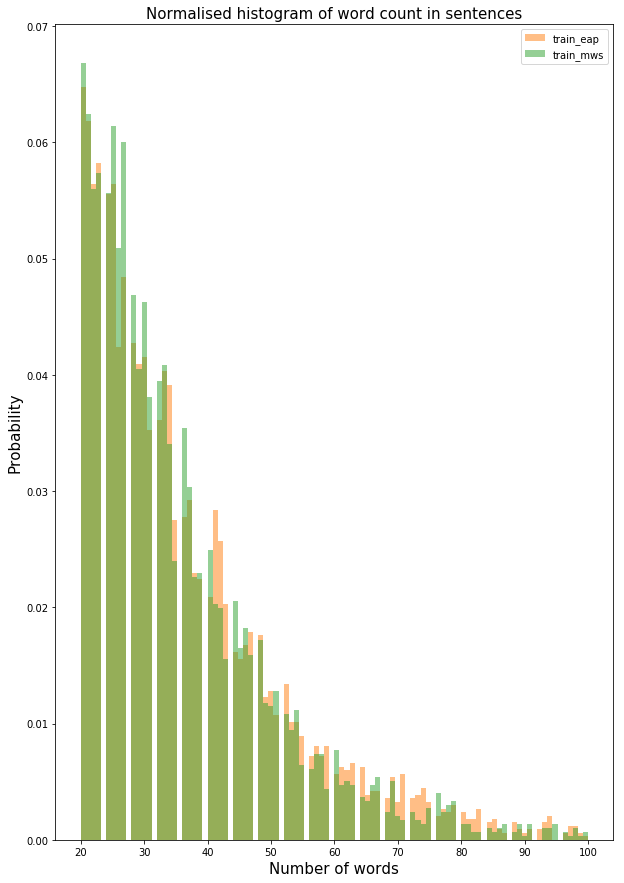

In [325]:
# Word Count
import seaborn as sns
pal = sns.color_palette()

train_eap = pd.Series(X_train_features[X_train_features['author'] == 'EAP']['text'].tolist())
train_mws = pd.Series(X_train_features[X_train_features['author'] == 'MWS']['text'].tolist())
train_hpl = pd.Series(X_train_features[X_train_features['author'] == 'HPL']['text'].tolist())
dist_train_eap = train_eap.apply(len)
dist_train_mws = train_mws.apply(len)
dist_train_hpl = train_hpl.apply(len)
plt.figure(figsize=(10, 15))
plt.hist(dist_train_eap, bins=100, range=[20, 100], color=pal[1], normed=True,alpha=0.5, label='train_eap')
plt.hist(dist_train_mws, bins=100, range=[20, 100], color=pal[2], normed=True,alpha=0.5, label='train_mws')
#plt.hist(dist_train_hpl, bins=100, range=[20, 100], color=pal[3], normed=True,alpha=0.5, label='train_hpl')
plt.title('Normalised histogram of word count in sentences', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

# print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
#                           dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

In [361]:
# Stop word analysis
from nltk.corpus import stopwords

dist_train_eap = [y for x in X_train_features[X_train_features['author'] == 'EAP']['text'] for y in x]
sw_dist_train_eap = [word for word in dist_train_eap if word in stopwords.words('english')]
print('Sentences with stop words for EAP: {:.2f}%'.format(len(sw_dist_train_eap)* 100/len(dist_train_eap) ))

dist_train_mws = [y for x in X_train_features[X_train_features['author'] == 'MWS']['text'] for y in x]
sw_dist_train_mws = [word for word in dist_train_mws if word in stopwords.words('english')]
print('Sentences with stop words for MWS: {:.2f}%'.format(len(sw_dist_train_mws)* 100/len(dist_train_mws) ))

dist_train_hpl = [y for x in X_train_features[X_train_features['author'] == 'HPL']['text'] for y in x]
sw_dist_train_hpl = [word for word in dist_train if word in stopwords.words('english')]
print('Sentences with stop words for HPL: {:.2f}%'.format(len(sw_dist_train_hpl)* 100/len(dist_train_hpl) ))
#

Sentences with stop words for EAP: 52.00%
Sentences with stop words for MWS: 52.00%
Sentences with stop words for HPL: 66.00%


Sentences with stop words: 52.00%


['this',
 'process',
 'however',
 'afforded',
 'me',
 'no',
 'means',
 'of',
 'ascertaining',
 'the',
 'dimensions',
 'of',
 'my',
 'dungeon',
 'as',
 'i',
 'might',
 'make',
 'its',
 'circuit',
 'and',
 'return',
 'to',
 'the',
 'point',
 'whence',
 'i',
 'set',
 'out',
 'without',
 'being',
 'aware',
 'of',
 'the',
 'fact',
 'so',
 'perfectly',
 'uniform',
 'seemed',
 'the',
 'wall',
 'in',
 'his',
 'left',
 'hand',
 'was',
 'a',
 'gold',
 'snuff',
 'box',
 'from',
 'which',
 'as',
 'he',
 'capered',
 'down',
 'the',
 'hill',
 'cutting',
 'all',
 'manner',
 'of',
 'fantastic',
 'steps',
 'he',
 'took',
 'snuff',
 'incessantly',
 'with',
 'an',
 'air',
 'of',
 'the',
 'greatest',
 'possible',
 'self',
 'satisfaction',
 'the',
 'astronomer',
 'perhaps',
 'at',
 'this',
 'point',
 'took',
 'refuge',
 'in',
 'the',
 'suggestion',
 'of',
 'non',
 'luminosity',
 'and',
 'here',
 'analogy',
 'was',
 'suddenly',
 'let',
 'fall',
 'the',
 'surcingle',
 'hung',
 'in',
 'ribands',
 'from',
 'my